# **[Baseline] Stock market news feed semantic analysis**

A Drive csatlakoztatása

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A dataset beolvasása.

In [42]:
!cp "/content/drive/MyDrive/Combined_News_DJIA.csv" "Combined_News_DJIA.csv"

In [43]:
# Check the copy is succesfull
read = !ls

assert read[0].find("Combined_News_DJIA.csv") != -1

A szükséges csomagok betöltése.

In [44]:
# Import the libraries 
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt
import string

A DJIA részvényhez tartozó árfolyam adatok letöltése 2008-06-08 és 2016-07-01 között, majd ezek megjelenítése.

In [45]:
# Load the stock data
df_stock = web.DataReader('DJIA', data_source='yahoo', start='2008-08-08', 
                          end='2016-07-01')
 
# Show the stock data
df_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11808.490234,11344.230469,11432.089844,11734.320312,4966810000,11734.320312
2008-08-11,11933.549805,11580.190430,11729.669922,11782.349609,5067310000,11782.349609
2008-08-12,11830.389648,11541.429688,11781.700195,11642.469727,4711290000,11642.469727
2008-08-13,11689.049805,11377.370117,11632.809570,11532.959961,4787600000,11532.959961
2008-08-14,11744.330078,11399.839844,11532.070312,11615.929688,4064000000,11615.929688
...,...,...,...,...,...,...
2016-06-27,17355.210938,17005.439453,17355.210938,17140.240234,5431220000,17140.240234
2016-06-28,17453.929688,17174.960938,17190.509766,17409.720703,4385810000,17409.720703
2016-06-29,17737.380859,17456.019531,17456.019531,17694.679688,4241740000,17694.679688


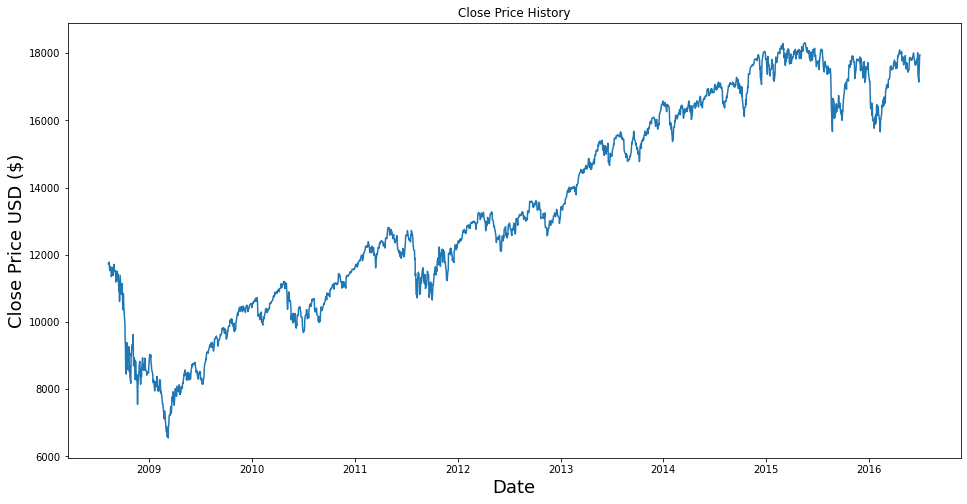

In [46]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_stock['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

A Dataset betöltése. A hírek 2008-08-08-tól 2016-07-01-ig tartanak.

In [47]:
df_combined = pd.read_csv('Combined_News_DJIA.csv', index_col = "Date")

df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

Hír nélküli napok megkeresése.

In [48]:
is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_combined[row_has_NaN]

rows_with_NaN

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",b'Two months after the Pakistani Army wrested ...,b'N. Korean cargo ship repels pirates off Soma...,b'Canada: Stephen Harper attempts to prop up r...,b'New geological data provides hope for claims...,b'Ukraine set to block Elton John adoption bec...,b'German plane makes emergency landing',b'Street artist catches chief of the Israeli a...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...","b""Cool Saudi Feminist calls for woman's right ...","b'According to satellite surveys, as much as 8...",b'Italian Prime Minister Silvio Berlusconi has...,"b""Don't blame the system for winter travel cha...",b'Christmas Eve around the world included the ...,b'Pope knocked down before Xmas mass',b'The solar salesman who put his cow on the ma...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,Next war in line: At least 20 South Sudanese a...,Bahraini protester ends hunger strike after be...,China tries to scare motorists into safer driving,Leaked Report Shows England Hit With Three Nuc...,Japans cyclone season approaches.,Have Oman and Qatar escaped the Arab revolts?,Rioters torch Australia asylum seeker detentio...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


Ezek kicserélése üres sztringekre.

In [49]:
df_combined = df_combined.replace(np.nan, " ")

is_NaN = df_combined.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_combined[row_has_NaN]

assert len(rows_with_NaN) is 0

df_combined

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel c

A napi hírek összefűzése egy string-be ötösével.

In [50]:
ROWS = 5
COLUMNS = len(df_combined)
news_sum = [[0 for i in range(COLUMNS)] for j in range(ROWS)] 
print(news_sum[0]) 

# Get column names
combined_column_names = []
for col in df_combined.columns:
  combined_column_names.append(col)
 
print(combined_column_names)

for i in range(len(df_combined)):
  for j in range(ROWS):
    temp = ""
    news = ""
    for k in range(ROWS):
      news = df_combined[combined_column_names[(j * ROWS) + (k + 1)]][i]
      if news[0] is "b":
        news = " " + news[1:]
      temp = temp + news
    news_sum[j][i] = temp

print(news_sum[0][1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [51]:
for j in range(len(combined_column_names) - 1):
  df_combined.drop(combined_column_names[j + 1], axis=1, inplace=True)

for i in range(ROWS):
  colum_name = "News_" + str(i)
  df_combined[colum_name] = news_sum[i]

df_combined

,Label,News_0,News_1,News_2,News_3,News_4
Date,,,,,,
2008-08-08,0,"""Georgia 'downs two Russian warplanes' as cou...",'150 Russian tanks have entered South Ossetia...,'Rice Gives Green Light for Israel to Attack ...,'Georgia Invades South Ossetia - if Russia ge...,'Why the Pentagon Thinks Attacking Iran is a ...
2008-08-11,1,'Why wont America and Nato help us? If they w...,'What were the Mossad with fraudulent New Zea...,'Russia presses deeper into Georgia; U.S. say...,'Israel and the US behind the Georgian aggres...,'Israeli Physicians Group Condemns State Tort...
2008-08-12,0,'Remember that adorable 9-year-old who sang a...,'Why Microsoft and Intel tried to kill the XO...,"'Gorbachev: ""Georgian military attacked the S...",'U.S. troops still in Georgia (did you know t...,'War in Georgia: The Israeli connection' 'All...
2008-08-13,0,' U.S. refuses Israel weapons to attack Iran:...,'China has moved 10 *million* quake survivors...,'USA to send fleet into Black Sea to help Geo...,'Elephants extinct by 2020?' 'US humanitarian...,'Gorbachev: We Had No Choice' 'Witness: Russi...
2008-08-14,1,'All the experts admit that we should legalis...,"""Rushdie Condemns Random House's Refusal to P...",'Moscow Made Plans Months Ago to Invade Georg...,'Bank analyst forecast Georgian crisis 2 days...,'Saudi Arabia: Mother moves to block child ma...
...,...,...,...,...,...,...
2016-06-27,0,Barclays and RBS shares suspended from trading...,Sterling dips below Friday's 31-year low amid ...,In a birth offering hope to a threatened speci...,German lawyers to probe Erdogan over alleged w...,Brexit opinion poll reveals majority don't wan...
2016-06-28,1,"2,500 Scientists To Australia: If You Want To ...","Brexit cost investors $2 trillion, the worst o...",British pound could hit history-making dollar ...,"US, Canada and Mexico pledge 50% of power from...",Jean-Claude Juncker asks Farage: Why are you h...
2016-06-29,1,Explosion At Airport In IstanbulYemeni former ...,A Muslim Shop in the UK Was Just Firebombed Wh...,A chatbot programmed by a British teenager has...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",More than 40 killed in Yemen suicide attacksGo...


Az első napi összefűzött hírek közüli első kiíratása.

In [52]:
df_combined["News_0"][0]

' "Georgia \'downs two Russian warplanes\' as countries move to brink of war" \'BREAKING: Musharraf to be impeached.\' \'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' \'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' "Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing"'

Egy új dataframebe újracsoportosítom a hír blokkokat a címkéjükkel, már a dátumok nélkül.

In [53]:
news_sum = []
label_sum = []

# Get column names
combined_column_names = []
for col in df_combined.columns:
  combined_column_names.append(col)
 
print(combined_column_names)

for i in range(len(df_combined)):
  for j in range(ROWS):
    news_sum.append(df_combined[combined_column_names[j + 1]][i])
    label_sum.append(df_combined[combined_column_names[0]][i])

df_sum_news_labels = pd.DataFrame(data = label_sum, index = None, columns = ["Label"])
df_sum_news_labels["News"] = news_sum

df_sum_news_labels


['Label', 'News_0', 'News_1', 'News_2', 'News_3', 'News_4']


,Label,News
0,0,"""Georgia 'downs two Russian warplanes' as cou..."
1,0,'150 Russian tanks have entered South Ossetia...
2,0,'Rice Gives Green Light for Israel to Attack ...
3,0,'Georgia Invades South Ossetia - if Russia ge...
4,0,'Why the Pentagon Thinks Attacking Iran is a ...
...,...,...
9940,1,A 117-year-old woman in Mexico City finally re...
9941,1,Brazil: Huge spike in number of police killing...
9942,1,France Cracks Down on Factory Farms - A viral ...
9943,1,"The United States has placed Myanmar, Uzbekist..."


A következőkben a hírek szövegeinek kódolása történik numerikus értékekre. Először a szövegek előfeldolgozásával kezdem: írásjelek eltávolítása, számok eltávolítása, felesleges szóközök eltávolítása, aztán minden szót kis kezdőbetűjü szóvá konvertálom.

In [54]:
# Removing punctuations
temp_news = []
for par in news_sum:
  temp_attach = ""
  for x in par:
    temp = " "
    if x not in string.punctuation:
      temp = x
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

news_sum = temp_news
temp_news = []

# Remove numbers
for par in news_sum:
  temp_attach = ""
  for x in par:
    temp = " "
    if not x.isdigit():
      temp = x
    temp_attach = temp_attach + "".join(temp)
  temp_news.append(temp_attach)

# Remove space
for i in range(len(temp_news)):    
  temp_news[i] = " ".join(temp_news[i].split())

# Converting headlines to lower case
for i in range(len(temp_news)): 
    temp_news[i] = temp_news[i].lower()

df_sum_news_labels["News"] = temp_news

df_sum_news_labels

,Label,News
0,0,georgia downs two russian warplanes as countri...
1,0,russian tanks have entered south ossetia whils...
2,0,rice gives green light for israel to attack ir...
3,0,georgia invades south ossetia if russia gets i...
4,0,why the pentagon thinks attacking iran is a ba...
...,...,...
9940,1,a year old woman in mexico city finally receiv...
9941,1,brazil huge spike in number of police killings...
9942,1,france cracks down on factory farms a viral vi...
9943,1,the united states has placed myanmar uzbekista...


Az első napi, előfeldolgozott, összefűzött hírek első csoportja.

In [58]:
df_sum_news_labels["News"][1]

'russian tanks entered south ossetia whilst georgia shoots two russian jets breaking georgia invades south ossetia russia warned would intervene side enemy combatent trials nothing sham salim haman sentenced years kept longer anyway feel like georgian troops retreat osettain capital presumably leaving several hundred people killed video u prep georgia war russia'

A következőkben az úgy nevezett töltelék szavakat (stop words) fogom eltávolítani.

In [56]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize  

stop_words = set(stopwords.words('english'))

filtered_sentence = []
news_sum = df_sum_news_labels["News"]

# Remove stop words
for par in news_sum:
  word_tokens = word_tokenize(par)
  temp_attach = ""
  for w in word_tokens:
    temp = " "
    if not w in stop_words:
      temp = temp + w
    temp_attach = temp_attach + "".join(temp)
  filtered_sentence.append(temp_attach)

# Remove space
for i in range(len(filtered_sentence)):    
  filtered_sentence[i] = " ".join(filtered_sentence[i].split())

df_sum_news_labels["News"] = filtered_sentence

df_sum_news_labels

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Label,News
0,0,georgia downs two russian warplanes countries ...
1,0,russian tanks entered south ossetia whilst geo...
2,0,rice gives green light israel attack iran says...
3,0,georgia invades south ossetia russia gets invo...
4,0,pentagon thinks attacking iran bad idea us new...
...,...,...
9940,1,year old woman mexico city finally received bi...
9941,1,brazil huge spike number police killings rio a...
9942,1,france cracks factory farms viral video campai...
9943,1,united states placed myanmar uzbekistan sudan ...


Az előbbi hírcsomag kiírása összehasonlításképp.

In [59]:
df_sum_news_labels["News"][1]

'russian tanks entered south ossetia whilst georgia shoots two russian jets breaking georgia invades south ossetia russia warned would intervene side enemy combatent trials nothing sham salim haman sentenced years kept longer anyway feel like georgian troops retreat osettain capital presumably leaving several hundred people killed video u prep georgia war russia'

Az adathalmaz véletlenszerű sorbarendezése.

In [60]:
from sklearn.utils import shuffle
SHUFFLE_CYCLE = 500

for i in range(SHUFFLE_CYCLE):
  df_sum_news_labels = shuffle(df_sum_news_labels)

df_sum_news_labels.reset_index(inplace=True, drop=True)

df_sum_news_labels

,Label,News
0,1,former australian pm writes gun reformu japan ...
1,0,global leaders global war drugs failed wtf nat...
2,1,google back china wait goojje hans rosling wor...
3,0,george clooney seeks expose fund profit wars a...
4,0,never seen years calder said heard japanese ta...
...,...,...
9940,0,refugee crisis nine month pregnant year old go...
9941,1,girls freed nigeria baby factory raid nigerian...
9942,1,happy endings ruled illegal southern china giv...
9943,0,traffic jam china miles long already going day...


Az adathalmazom felbontása tanító, validáló és teszt adathalmazra.

In [62]:
# Create datasets
news_string = (df_sum_news_labels['News'].values).astype('U')
 
INPUT_SIZE = len(df_sum_news_labels)
# 80% train -> 8% valid, 72% train; 20% test
TRAIN_SIZE = int(0.8 * INPUT_SIZE) 
VALID_SIZE = int(0.1 * TRAIN_SIZE)
print(INPUT_SIZE, TRAIN_SIZE, VALID_SIZE)

9945 7956 795


In [63]:
train_dataset = df_sum_news_labels[:TRAIN_SIZE - VALID_SIZE] 

train_dataset

,Label,News
0,1,former australian pm writes gun reformu japan ...
1,0,global leaders global war drugs failed wtf nat...
2,1,google back china wait goojje hans rosling wor...
3,0,george clooney seeks expose fund profit wars a...
4,0,never seen years calder said heard japanese ta...
...,...,...
7156,1,end war drugs say nobel prize winning economis...
7157,0,russian lawyer defended journalists poisoned f...
7158,0,right wing group mapping jerusalem businesses ...
7159,1,meet noemi letizia year old hottie behind ital...


In [64]:
valid_dataset = df_sum_news_labels[TRAIN_SIZE - VALID_SIZE:TRAIN_SIZE] 

valid_dataset

,Label,News
7161,0,nasa says congress cuts mean needed buy rides ...
7162,0,london birmingham men thought protecting commu...
7163,1,afghan mystery large shipments gold leaving co...
7164,0,richard stallman actions mastercard amazon hac...
7165,1,portuguese dismayed spelling language driven b...
...,...,...
7951,1,russia backs keeping u force iraq gop donors c...
7952,0,muslim politician india offered charlie hebdo ...
7953,1,syrias population control strategy scrutiny da...
7954,1,secret behind travel mayhem five inches snow s...


In [65]:
test_dataset = df_sum_news_labels[TRAIN_SIZE:]

test_dataset

,Label,News
7956,1,vancouver riot pics hong kong declares scarlet...
7957,0,imf says us must solve debt crisishealth ocean...
7958,0,bbc news georgia president mikheil saakashvili...
7959,0,surprise dictator responsible killing thousand...
7960,0,russia u sign treaty prolonging iss operations...
...,...,...
9940,0,refugee crisis nine month pregnant year old go...
9941,1,girls freed nigeria baby factory raid nigerian...
9942,1,happy endings ruled illegal southern china giv...
9943,0,traffic jam china miles long already going day...


Ezek lementése .tsv fájlokba, hogy majd betölthessem a pyTorch modulnak.

In [66]:
train_dataset.to_csv('train.tsv', sep = '\t', index=False)
valid_dataset.to_csv('valid.tsv', sep = '\t', index=False)
test_dataset.to_csv('test.tsv', sep = '\t', index=False)

A kódolandó szövegek és a címkék formátumának a megadása.

In [67]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

NEWS = data.Field(tokenize = 'spacy', include_lengths = True)
LABELS = data.LabelField(dtype = torch.float)

Az adathalmazok betöltése a pyTorch modulhoz.

In [68]:
fields = [('l', LABELS), ('n', NEWS)]

In [69]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = "",
                                        train = "train.tsv",
                                        validation = "valid.tsv",
                                        test = "test.tsv",
                                        format = "tsv",
                                        fields = fields,
                                        skip_header = True
)

In [70]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))

{'l': '1', 'n': ['former', 'australian', 'pm', 'writes', 'gun', 'reformu', 'japan', 'review', 'defense', 'guidelines', 'amid', 'tension', 'chinathe', 'gravest', 'allegations', 'conflating', 'critique', 'israel', 'anti', 'semitismfrench', 'ground', 'troops', 'combat', 'central', 'maliattackers', 'kill', 'injure', 'workers', 'algeria', 'americans', 'held', 'hostage']}
{'l': '0', 'n': ['nasa', 'says', 'congress', 'cuts', 'mean', 'needed', 'buy', 'rides', 'russian', 'rocketsmore', 'dutch', 'cities', 'may', 'join', 'basic', 'income', 'experimentyou', 'taught', 'students', 'releasing', 'islamic', 'state', 'indians', 'abducted', 'libyasurvey', 'suggests', 'strong', 'popular', 'support', 'jew', 'free', 'romaniabritish', 'truck', 'driver', 'radios', 'international', 'space', 'station', 'garden', 'shed']}
{'l': '1', 'n': ['vancouver', 'riot', 'pics', 'hong', 'kong', 'declares', 'scarlet', 'fever', 'outbreak', 'thousands', 'infected', 'city', 'amp', 'elsewhere', 'chinathe', 'uk', 'government', 'm

Előtanult szókódoló használata a szótár létrehozásához, csak a tanító adathalmazt lehet felhasználni.

In [71]:
MAX_VOCAB_SIZE = 25000

NEWS.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABELS.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:51, 2.10MB/s]                           
 99%|█████████▉| 397978/400000 [00:16<00:00, 25973.88it/s]

A létrehozott szótár ellenőrzése.

In [72]:
print(f"Unique tokens in TEXT vocabulary: {len(NEWS.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABELS.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


A leggyakoribb szavak és a címkék ellenőrzése.

In [73]:
print(NEWS.vocab.freqs.most_common(20))
print(LABELS.vocab.stoi)

[('us', 2050), ('says', 1787), ('new', 1631), ('world', 1568), ('government', 1447), ('israel', 1317), ('people', 1301), ('police', 1292), ('china', 1270), ('u', 1264), ('war', 1118), ('year', 1101), ('years', 1029), ('one', 1013), ('president', 983), ('russia', 971), ('first', 949), ('killed', 940), ('israeli', 898), ('uk', 878)]
defaultdict(<function _default_unk_index at 0x7f6a106c91e0>, {'1': 0, '0': 1})


Bemenő csomagok, futtató eszköz és az iterátorok definiálása.

In [74]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key = lambda x: x.n, #sort by n attribute (quote)
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

cuda


 99%|█████████▉| 397978/400000 [00:30<00:00, 25973.88it/s]

In [75]:
print('Train:')
for batch in train_iterator:
    print(batch)
    
print('Valid:')
for batch in valid_iterator:
    print(batch)
    
print('Test:')
for batch in test_iterator:
    print(batch)

Train:

[torchtext.data.batch.Batch of size 64]
	[.l]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.n]:('[torch.cuda.LongTensor of size 112x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')

[torchtext.data.batch.Batch of size 64]
	[.l]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.n]:('[torch.cuda.LongTensor of size 110x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')

[torchtext.data.batch.Batch of size 64]
	[.l]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.n]:('[torch.cuda.LongTensor of size 105x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')

[torchtext.data.batch.Batch of size 64]
	[.l]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.n]:('[torch.cuda.LongTensor of size 115x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')

[torchtext.data.batch.Batch of size 64]
	[.l]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
	[.n]:('[torch.cuda.LongTensor of size 102x64 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')

[torchtext.data.batch.

LSTM modell felépítése.

In [77]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

LSTM modell létrehozása.

In [155]:
INPUT_DIM = len(NEWS.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.75
PAD_IDX = NEWS.vocab.stoi[NEWS.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

A modell tanítható paramétereinek megvizsgálása.

In [156]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


A korábban létrehozott szótár használata a modell esetében.

In [157]:
pretrained_embeddings = NEWS.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


Az előre inicializált súlyok lecserélére az előtanítottakra.

In [158]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.3309,  1.0111,  1.5401,  ...,  0.0306,  0.5924,  0.4133],
        ...,
        [ 0.1269, -0.7718, -0.5289,  ...,  0.0105, -0.4889,  0.1622],
        [-0.0648, -1.1718,  0.2649,  ...,  0.9880,  0.1578, -0.2805],
        [-1.4333, -1.3830, -0.6717,  ...,  1.1859,  0.8712, -0.0195]])

A térköz és az ismeretlen kódok súlyának nullára állítása.

In [159]:
UNK_IDX = NEWS.vocab.stoi[NEWS.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3309,  1.0111,  1.5401,  ...,  0.0306,  0.5924,  0.4133],
        ...,
        [ 0.1269, -0.7718, -0.5289,  ...,  0.0105, -0.4889,  0.1622],
        [-0.0648, -1.1718,  0.2649,  ...,  0.9880,  0.1578, -0.2805],
        [-1.4333, -1.3830, -0.6717,  ...,  1.1859,  0.8712, -0.0195]])


A modell tanítása következik, amit először az optimalizáló függvény meghatározásával kezdem.

In [160]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

Ezek után a költséggfüggvény definiálása következik, majd a modellel együtt az eszközre illesztése.

In [161]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

A pontosság számítására használandó függvény definiálása.

In [162]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

A tanító függvény definiálása.

In [163]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() # turn on drop out
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.n
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.l)
        
        acc = binary_accuracy(predictions, batch.l)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

A modell tesztelésének definiálása.

In [164]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval() # turn off drop out
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.n
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.l)
            
            acc = binary_accuracy(predictions, batch.l)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Az epoch-ok idejének mérésére használt függvény definiálása.

In [165]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

A modell tanítása.

In [166]:
N_EPOCHS = 50

best_valid_loss = float('inf')

no_improve_counter = 0
last_valid_acc = 0

train_loss_array = []
train_acc_array = []
valid_loss_array = []
valid_acc_array = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_array.append(train_loss)
    train_acc_array.append(train_acc)
    valid_loss_array.append(valid_loss)
    valid_acc_array.append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    # early leave
    no_improvements = ""

    if last_valid_acc > valid_acc:
        best_valid_loss = valid_loss
        no_improve_counter = no_improve_counter + 1
        no_improvements = "| There were no improvements on the validation set!"
    else:
        no_improve_counter = 0

    last_valid_acc = valid_acc

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s {no_improvements}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if no_improve_counter is 5:
      print(f'The model is not improving, going to stop.')
      break

    if train_acc > 0.95:
      print(f'The model training is finished.')
      break 

torch.save(model.state_dict(), 'last-model.pt')      

Epoch: 01 | Epoch Time: 0m 5s 
	Train Loss: 0.691 | Train Acc: 53.27%
	 Val. Loss: 0.701 |  Val. Acc: 50.82%
Epoch: 02 | Epoch Time: 0m 4s | There were no improvements on the validation set!
	Train Loss: 0.692 | Train Acc: 52.28%
	 Val. Loss: 0.697 |  Val. Acc: 50.70%
Epoch: 03 | Epoch Time: 0m 4s | There were no improvements on the validation set!
	Train Loss: 0.691 | Train Acc: 53.01%
	 Val. Loss: 0.697 |  Val. Acc: 49.98%
Epoch: 04 | Epoch Time: 0m 4s 
	Train Loss: 0.687 | Train Acc: 55.38%
	 Val. Loss: 0.700 |  Val. Acc: 50.98%
Epoch: 05 | Epoch Time: 0m 4s 
	Train Loss: 0.684 | Train Acc: 55.38%
	 Val. Loss: 0.701 |  Val. Acc: 51.63%
Epoch: 06 | Epoch Time: 0m 4s | There were no improvements on the validation set!
	Train Loss: 0.678 | Train Acc: 56.52%
	 Val. Loss: 0.728 |  Val. Acc: 50.02%
Epoch: 07 | Epoch Time: 0m 4s | There were no improvements on the validation set!
	Train Loss: 0.666 | Train Acc: 59.61%
	 Val. Loss: 0.714 |  Val. Acc: 48.50%
Epoch: 08 | Epoch Time: 0m 4s 
	T

A tanítási és validációs metrikák ábrázolása.

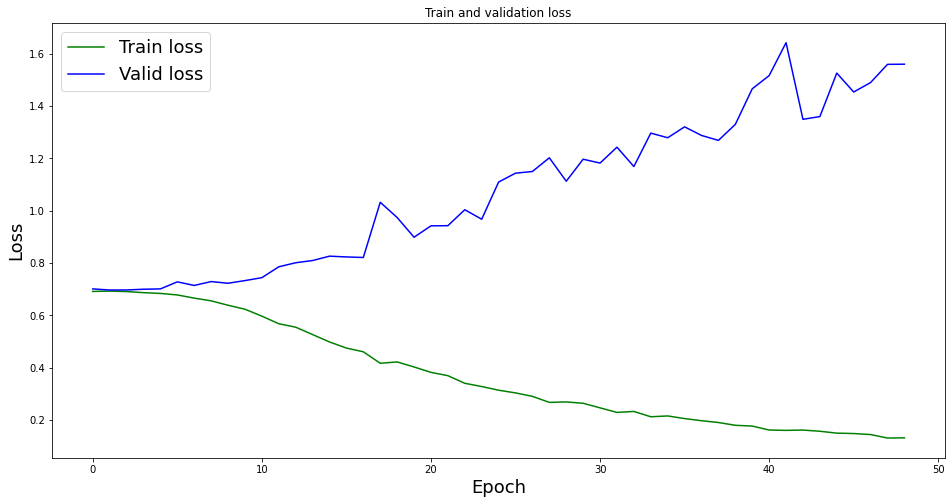

In [170]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation loss')
plt.plot(train_loss_array, color = "green", label = "Train loss")
plt.plot(valid_loss_array, color = "blue", label = "Valid loss")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend(fontsize=18)
plt.show()

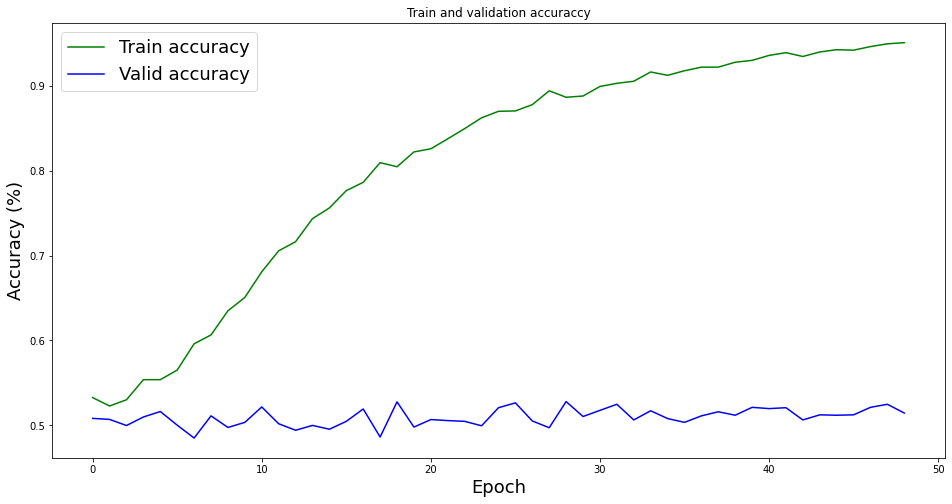

In [171]:
# Visualize the training
plt.figure(figsize=(16,8))
plt.title('Train and validation accuraccy')
plt.plot(train_acc_array, color = "green", label = "Train accuracy")
plt.plot(valid_acc_array, color = "blue", label = "Valid accuracy")
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy (%)',fontsize=18)
plt.legend(fontsize=18)
plt.show()

A modell tesztelése.

In [172]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'-- Best model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model.load_state_dict(torch.load('last-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'-- Last model --')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

-- Best model --
Test Loss: 1.539 | Test Acc: 51.40%
-- Last model --
Test Loss: 1.658 | Test Acc: 49.11%
